In [1]:
import mne
import os
import os.path as op
import numpy as np
import pickle
from warnings import filterwarnings
from sys import argv
import matplotlib.pyplot as plt
from stormdb.access import Query
import pandas as pd
from src.preprocessing import WM_epoching, main_task_events_fun, default_events_fun
import src.decoding_functions as dfun
from sklearn.linear_model import LinearRegression
import importlib
importlib.reload(dfun)

filterwarnings("ignore", category=DeprecationWarning)

In [134]:
## Define relevant variables
# Project info
project = 'MINDLAB2020_MEG-AuditoryPatternRecognition'
project_dir = '/projects/' + project
os.environ['MINDLABPROJ']= project
os.environ['MNE_ROOT']='~/miniconda3/envs/mne'
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.2'

#Paths
raw_path = project_dir + '/scratch/maxfiltered_data/tsss_st16_corr96'
ica_path = project_dir + '/scratch/working_memory/ICA'
avg_path = project_dir + '/scratch/working_memory/averages'
log_path = project_dir + '/misc/working_memory_logs'

subjects_dir = project_dir + '/scratch/fs_subjects_dir'
fwd_path = project_dir + '/scratch/forward_models'

# Subject info:
qy = Query(project)
subs = qy.get_subjects()
scode = 24
if len(argv) > 1:
    scode = int(argv[1])

#Other variables
sub = subs[scode-1] #'0002_BYG'#'0002_BYG'#'0008_HMD'#'0002_BYG'
fig_dir = avg_path + '/figures/' + sub + '/'
data_dir = avg_path + '/data/' + sub + '/'

conds_orig = ['loc','main','inv'] #  ['mainv2','invv2']
conds = ['localizer','maintenance','manipulation']
lnames = [None,'recognize','invert'] # Log file names to exclude wrong trials
tmin = [0,1.75,1.75] # epoch tmin
tmax = [1.8,4,4] # epoch tmax
event_funs = [default_events_fun,  main_task_events_fun, main_task_events_fun]

In [110]:
#Epoch data
reject = dict(mag = 4e-12, grad = 4000e-13) # rejection criteria

# Initialize
epochs = {}
print('\n epoching \n')
for cidx, c in enumerate(conds_orig):
    nc = conds[cidx] # new condition name
     
    # Files to retrieve
    fname = os.path.join(raw_path, sub, c + '_raw_tsss.fif')
    icaname = os.path.join(ica_path,sub, c + '_raw_tsss-ica.fif')
    if lnames[cidx]:
        lfname = op.join(log_path, sub[0:4] + '_' + lnames[cidx] + '_MEG.csv')
        events_fun_kwargs = {'cond': nc, 'lfname': lfname}
    else:
        events_fun_kwargs = {}
        
    print(tmin[cidx])
    print(tmax[cidx])
    #Epoching proper:
    epochs[nc] = WM_epoching(data_path = fname, ica_path = icaname, tmin = tmin[cidx], tmax = tmax[cidx],
                                l_freq = None, h_freq = None, resample = 100, bads = [],
                                baseline = None, notch_filter = 50,
                                events_fun = event_funs[cidx], 
                                events_fun_kwargs = events_fun_kwargs,
                                reject=reject)


 epoching 

0
1.8
Opening raw data file /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/maxfiltered_data/tsss_st16_corr96/0024_JSV/loc_raw_tsss.fif...
    Range : 10000 ... 381999 =     10.000 ...   381.999 secs
Ready.
Reading 0 ... 371999  =      0.000 ...   371.999 secs...
Reading /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/ICA/0024_JSV/loc_raw_tsss-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 1 ICA component
    Projecting back using 306 PCA components
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 

In [125]:
# Perform localizer decoding
smooth_kwargs = {'tstep': .01, 'twin': .05}
gen, lpatterns, lfilters, scores, times = dfun.WM_time_gen_classify({'localizer': epochs['localizer']}, mode='sensor',
                                                                  kind='Sliding', inv = None, score = True, n_features = 'all',
                                                                  twindows = [0,1.8], l_freq=None, h_freq = None,
                                                                 smooth = smooth_kwargs, save_filters=None, save_scores = None,
                                                                 save_gen=None, save_patterns=None, penalty='l1')

fitting  localizer


  0%|          | Fitting SlidingEstimator : 0/178 [00:00<?,       ?it/s]

extractig patterns and filters
scoring  localizer_from_localizer


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
  3%|▎         | Fitting SlidingEstimator : 5/178 [00:00<00:04,   36.67it/s]/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distu

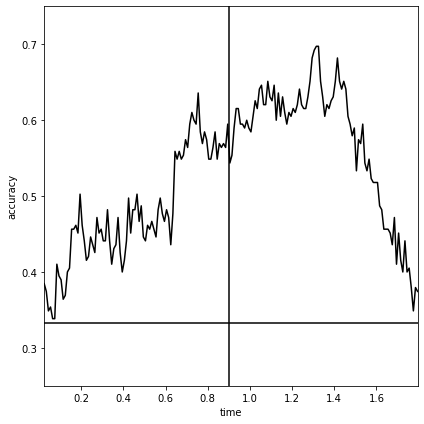

In [136]:
dfun.plot_diagonal_accuracy(scores, times, nrows=1, ncols=1,vlines=[.9],hlines=[.9], chance=1/3,savefig=None, ylims = [.25,.75])
plt.savefig(fig_dir + sub + '_localizer_diagonal_accuracy.pdf')

No projector specified for this dataset. Please consider the method self.add_proj.


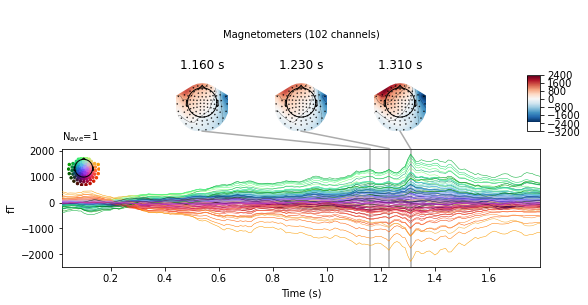

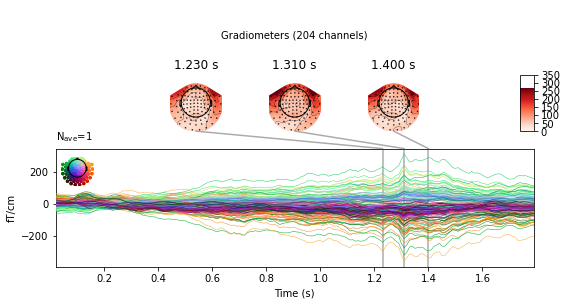

No projector specified for this dataset. Please consider the method self.add_proj.


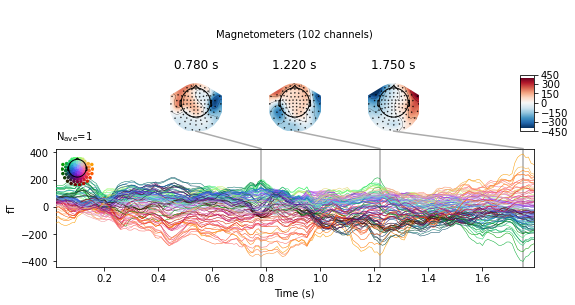

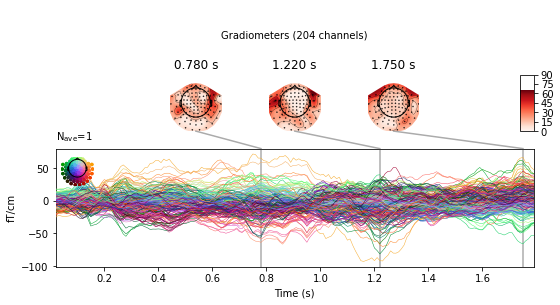

No projector specified for this dataset. Please consider the method self.add_proj.


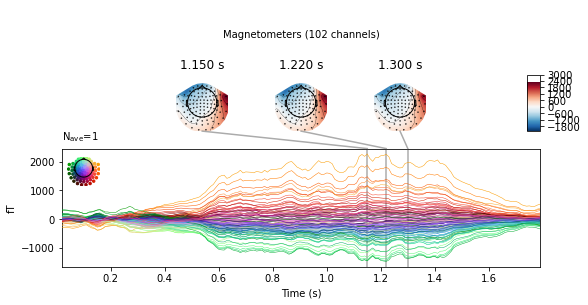

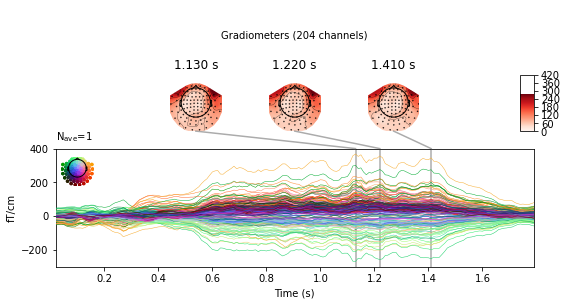

In [146]:
for lp in lpatterns:
    cpf = lpatterns[lp].plot_joint()
    cpf[0].savefig(fig_dir + sub + '_' + lp + '_patterns_mag.pdf')
    cpf[1].savefig(fig_dir + sub + '_' + lp + '_patterns_grad.pdf')   

In [147]:
tix = [np.argmax(scores['localizer_from_localizer']*(times['localizer']<.8)), 
       np.argmax(scores['localizer_from_localizer']*(times['localizer']>=.8))]
# tix = [np.argmin(np.abs(times['localizer'] - x)) for x in [0.28,1.8]]
print(np.array(tix), times['localizer'][tix])
probs, times2, events = dfun.get_probs(gen['localizer'], epochs, tix, blocks = ['maintenance','manipulation'])

[ 73 129] [0.755 1.315]


In [156]:
delays = np.arange(1,101)
betas = {b: dfun.sequence_betas(probs[b], delays) for b in probs}

Model  1  trial  1
Model  1  trial  2
Model  1  trial  3
Model  1  trial  4
Model  1  trial  5
Model  1  trial  6
Model  1  trial  7
Model  1  trial  8
Model  1  trial  9
Model  1  trial  10
Model  1  trial  11
Model  1  trial  12
Model  1  trial  13
Model  1  trial  14
Model  1  trial  15
Model  1  trial  16
Model  1  trial  17
Model  1  trial  18
Model  1  trial  19
Model  1  trial  20
Model  1  trial  21
Model  1  trial  22
Model  1  trial  23
Model  1  trial  24
Model  1  trial  25
Model  1  trial  26
Model  1  trial  27
Model  1  trial  28
Model  1  trial  29
Model  1  trial  30
Model  1  trial  31
Model  1  trial  32
Model  1  trial  33
Model  1  trial  34
Model  1  trial  35
Model  1  trial  36
Model  1  trial  37
Model  1  trial  38
Model  1  trial  39
Model  1  trial  40
Model  1  trial  41
Model  1  trial  42
Model  1  trial  43
Model  1  trial  44
Model  1  trial  45
Model  1  trial  46
Model  1  trial  47
Model  1  trial  48
Model  1  trial  49
Model  2  trial  1
Model  2  

In [157]:
probs_file = open(data_dir + sub + '_predicted_proba.p','wb')
pickle.dump({'probs': probs, 'times': times2, 'events': events, 'delays': delays, 'betas': betas}, probs_file)
probs_file.close()

block: maintenance
block: manipulation
block: maintenance
block: manipulation


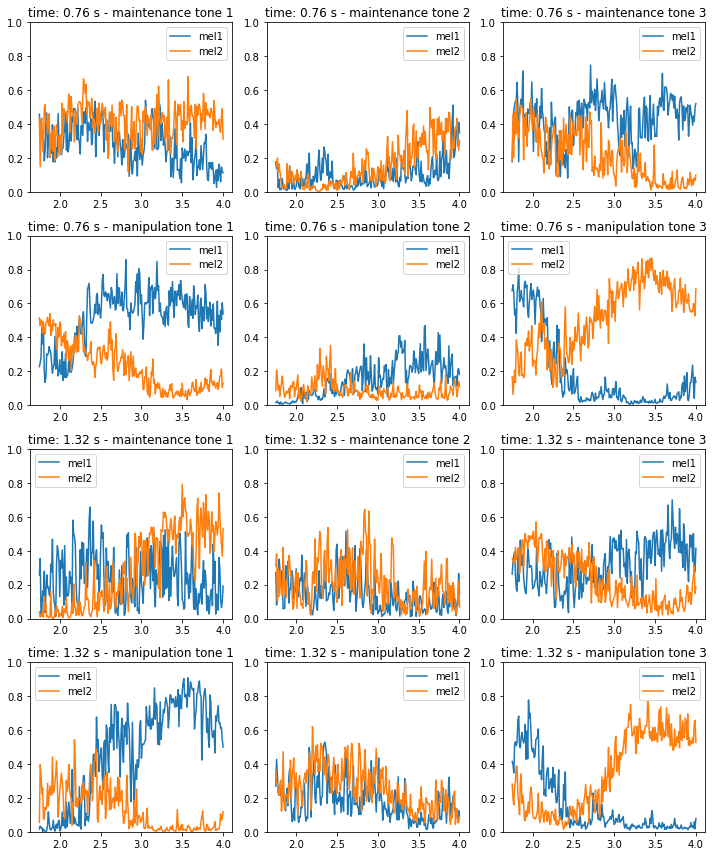

In [155]:
fig, ax = plt.subplots(4,3, figsize=(10,12))
for ctx, ct in enumerate(tix):
    for bix, b in enumerate(probs):
        print('block: '+ b)
        event_sel = {m: np.where([a in np.unique(epochs[b][m].events[:,2]) for a in events[b][:,2]]) for m in ['mel1','mel2']}
        event_sel = {e: event_sel[e][0] for e in event_sel}
        for t in range(probs[b].shape[3]):
            cbix = 2*ctx + bix  
            ax[cbix,t].plot(times2[b],np.median(probs[b][ctx,event_sel['mel1'],:,t],0))
            ax[cbix,t].plot(times2[b],np.median(probs[b][ctx,event_sel['mel2'],:,t],0))
            ax[cbix,t].set_ylim([0,1])
            ax[cbix,t].set_title('time: ' + str(np.round(times['localizer'][ct],2)) + ' s - ' + b + ' ' + 'tone ' + str(t+1))
            ax[cbix,t].legend(['mel1','mel2'])
plt.tight_layout()
plt.savefig(fig_dir + sub + '_probs_timecourses.pdf')

In [154]:
patterns = np.array([[[1,1,1],[1,1,1],[1,1,1]],
                     [[1,0,0],[0,1,0],[0,0,1]],
                    [[0,0,0],[1,0,0],[0,1,0]],
                    [[0,1,0],[0,0,1],[0,0,0]]])
patterns = patterns.reshape(patterns.shape[0],-1).T   
print(patterns)

[[1 1 0 0]
 [1 0 0 1]
 [1 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 0 0 1]
 [1 0 0 0]
 [1 0 1 0]
 [1 1 0 0]]


In [122]:
perms = {}
for b in betas:
    print('block: '+ b)
    event_sel = {m: np.where([a in np.unique(epochs[b][m].events[:,2]) for a in events[b][:,2]]) for m in ['mel1','mel2']}
    event_sel = {e: event_sel[e][0] for e in event_sel}
    perms[b] = dfun.seq_permutation_within(betas[b], patterns, nperm = 200, event_sel = event_sel)

block: maintenance
testing events: mel1
testing regressor: forward
permutation  1  /  200
permutation  2  /  200
permutation  3  /  200
permutation  4  /  200
permutation  5  /  200
permutation  6  /  200
permutation  7  /  200
permutation  8  /  200
permutation  9  /  200
permutation  10  /  200
permutation  11  /  200
permutation  12  /  200
permutation  13  /  200
permutation  14  /  200
permutation  15  /  200
permutation  16  /  200
permutation  17  /  200
permutation  18  /  200
permutation  19  /  200
permutation  20  /  200
permutation  21  /  200
permutation  22  /  200
permutation  23  /  200
permutation  24  /  200
permutation  25  /  200
permutation  26  /  200
permutation  27  /  200
permutation  28  /  200
permutation  29  /  200
permutation  30  /  200
permutation  31  /  200
permutation  32  /  200
permutation  33  /  200
permutation  34  /  200
permutation  35  /  200
permutation  36  /  200
permutation  37  /  200
permutation  38  /  200
permutation  39  /  200
permut

permutation  134  /  200
permutation  135  /  200
permutation  136  /  200
permutation  137  /  200
permutation  138  /  200
permutation  139  /  200
permutation  140  /  200
permutation  141  /  200
permutation  142  /  200
permutation  143  /  200
permutation  144  /  200
permutation  145  /  200
permutation  146  /  200
permutation  147  /  200
permutation  148  /  200
permutation  149  /  200
permutation  150  /  200
permutation  151  /  200
permutation  152  /  200
permutation  153  /  200
permutation  154  /  200
permutation  155  /  200
permutation  156  /  200
permutation  157  /  200
permutation  158  /  200
permutation  159  /  200
permutation  160  /  200
permutation  161  /  200
permutation  162  /  200
permutation  163  /  200
permutation  164  /  200
permutation  165  /  200
permutation  166  /  200
permutation  167  /  200
permutation  168  /  200
permutation  169  /  200
permutation  170  /  200
permutation  171  /  200
permutation  172  /  200
permutation  173  /  200


permutation  67  /  200
permutation  68  /  200
permutation  69  /  200
permutation  70  /  200
permutation  71  /  200
permutation  72  /  200
permutation  73  /  200
permutation  74  /  200
permutation  75  /  200
permutation  76  /  200
permutation  77  /  200
permutation  78  /  200
permutation  79  /  200
permutation  80  /  200
permutation  81  /  200
permutation  82  /  200
permutation  83  /  200
permutation  84  /  200
permutation  85  /  200
permutation  86  /  200
permutation  87  /  200
permutation  88  /  200
permutation  89  /  200
permutation  90  /  200
permutation  91  /  200
permutation  92  /  200
permutation  93  /  200
permutation  94  /  200
permutation  95  /  200
permutation  96  /  200
permutation  97  /  200
permutation  98  /  200
permutation  99  /  200
permutation  100  /  200
permutation  101  /  200
permutation  102  /  200
permutation  103  /  200
permutation  104  /  200
permutation  105  /  200
permutation  106  /  200
permutation  107  /  200
permutat

permutation  198  /  200
permutation  199  /  200
permutation  200  /  200
calculating pvals
testing regressor: backward
permutation  1  /  200
permutation  2  /  200
permutation  3  /  200
permutation  4  /  200
permutation  5  /  200
permutation  6  /  200
permutation  7  /  200
permutation  8  /  200
permutation  9  /  200
permutation  10  /  200
permutation  11  /  200
permutation  12  /  200
permutation  13  /  200
permutation  14  /  200
permutation  15  /  200
permutation  16  /  200
permutation  17  /  200
permutation  18  /  200
permutation  19  /  200
permutation  20  /  200
permutation  21  /  200
permutation  22  /  200
permutation  23  /  200
permutation  24  /  200
permutation  25  /  200
permutation  26  /  200
permutation  27  /  200
permutation  28  /  200
permutation  29  /  200
permutation  30  /  200
permutation  31  /  200
permutation  32  /  200
permutation  33  /  200
permutation  34  /  200
permutation  35  /  200
permutation  36  /  200
permutation  37  /  200


permutation  130  /  200
permutation  131  /  200
permutation  132  /  200
permutation  133  /  200
permutation  134  /  200
permutation  135  /  200
permutation  136  /  200
permutation  137  /  200
permutation  138  /  200
permutation  139  /  200
permutation  140  /  200
permutation  141  /  200
permutation  142  /  200
permutation  143  /  200
permutation  144  /  200
permutation  145  /  200
permutation  146  /  200
permutation  147  /  200
permutation  148  /  200
permutation  149  /  200
permutation  150  /  200
permutation  151  /  200
permutation  152  /  200
permutation  153  /  200
permutation  154  /  200
permutation  155  /  200
permutation  156  /  200
permutation  157  /  200
permutation  158  /  200
permutation  159  /  200
permutation  160  /  200
permutation  161  /  200
permutation  162  /  200
permutation  163  /  200
permutation  164  /  200
permutation  165  /  200
permutation  166  /  200
permutation  167  /  200
permutation  168  /  200
permutation  169  /  200


In [159]:
perms_file = open(data_dir + sub + '_sequenceness.p','wb')
pickle.dump({'perms': perms, 'patterns': patterns}, perms_file)
perms_file.close()

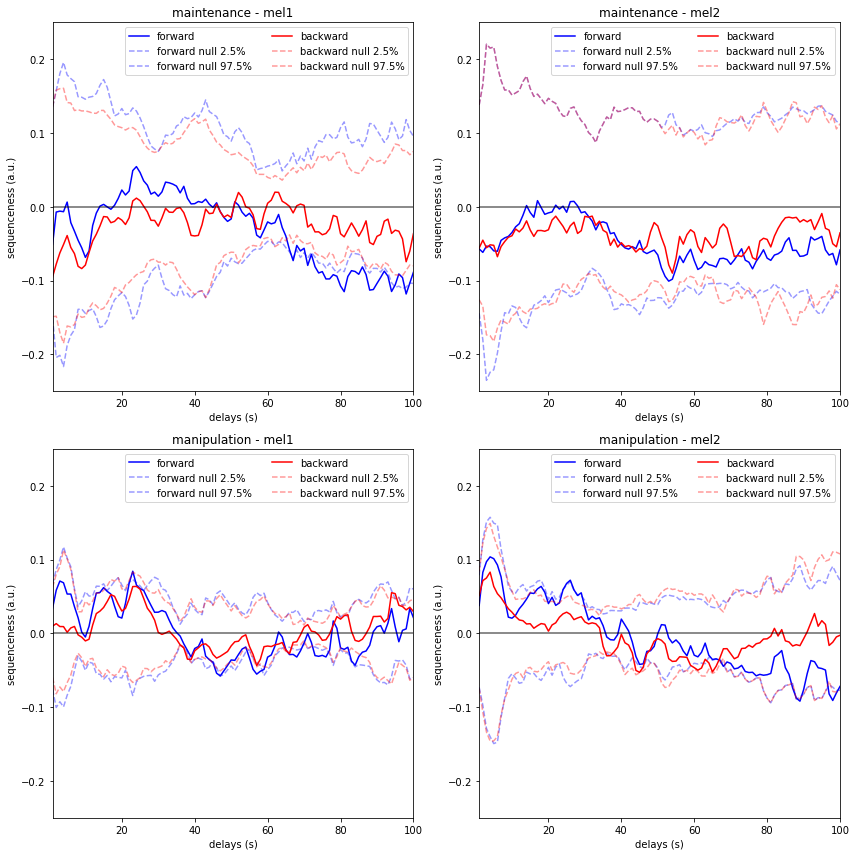

In [160]:
# Plot coefficients
patterns = {'forward': 2,'backward': 3}
colors = {'forward': 'b','backward': 'r'}
blocks = [b for b in perms]
mels = [m for m in perms[blocks[0]]['stat']]
fig, ax = plt.subplots(len(blocks),len(mels), figsize=[12,12])
for bix,b in enumerate(blocks):
    for mix,m in enumerate(mels):
        for p in patterns:
            pix = patterns[p]
            sig_lines = np.percentile(perms[b]['null'][m][p],[2.5,97.5], axis = 0)[:,1,:,pix]            
            ax[bix,mix].plot(delays, perms[b]['stat'][m][1,:,pix],color=colors[p])
            ax[bix,mix].plot(delays, sig_lines.T, color=colors[p], linestyle='--',alpha=.4)
            
        ax[bix,mix].axhline(0,color='k',alpha = .6)
        ax[bix,mix].set_xlabel('delays (s)')
        ax[bix,mix].set_xlim(delays[[0,-1]])
        ax[bix,mix].set_ylim([-.25,.25])
        ax[bix,mix].set_ylabel('sequenceness (a.u.)')
        ax[bix,mix].legend(['forward','forward null 2.5%','forward null 97.5%', 'backward','backward null 2.5%','backward null 97.5%'],ncol=2)
        ax[bix,mix].set_title(b + ' - ' + m)
plt.tight_layout()
plt.savefig(fig_dir + sub + '_sequenceness.pdf')